# Time series analysis in the MTA turnstile data


## Introduction

The main objective of this work is to analyze MTA turnstile data in order to find outliers, trends and periodicity in it.

In [20]:
import numpy as np
import pandas as pd
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn
from IPython.display import Image
%matplotlib inline

In [2]:
#download data
url = 'https://github.com/fedhere/PUI2016_fb55/raw/master/HW9_fb55/MTA_Fare.npy'
os.system('wget ' + url)
os.system("mv " + 'MTA_Fare.npy ' + os.getenv("PUIDATA"))


0

In [3]:
#load rawData
rawData = np.load(os.getenv("PUIDATA") + '/MTA_Fare.npy')
print rawData.shape

(600, 23, 194)


Our data set consist in ridership records of 600 subway stations, for 23 card types across 194 weeks from 05/21/2010 to 02/21/2014.

In [4]:
#change nas
data = np.where(rawData == -1, np.nan, rawData)

# Part I - Identifying the most prominent event in the series for all the stations and card types


Our main objetive here is to see if in the whole series there are some prominent events. For that purpose, we get the average across all stations and for all the card types. The result is a time series wich representes the overall activity in the subway lines for NYC.

In [5]:
stationsMean = np.nanmean(data,axis=0)
allMeans = np.nanmean(stationsMean,axis=0)
allMeans.shape

/home/pipe/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


(194,)

In [6]:
#weeks 05/21/2010 to 02/21/2014.
import datetime

start = datetime.datetime.strptime("05/21/2010","%m/%d/%Y")
end = datetime.datetime.strptime("02/21/2014", "%m/%d/%Y")
weeks = []
base = start
for i in range(194):
    weeks.append(base)
    base = base + datetime.timedelta(days=7)
weeks = np.array(weeks)



In [7]:
rng = pd.date_range('05/21/2010',periods = 194, freq = 'w')

To detect this unusual events in ridership, first we must set a threshold beyond which we consider that event interesting enough. A first visual inspection of data shows a week where ridership as an important drop. Therefore, we'll stablish a threshold of 3 times the standar deviation of the ridership.

In [9]:
threshold = allMeans.mean() - 3 * allMeans.std()

''

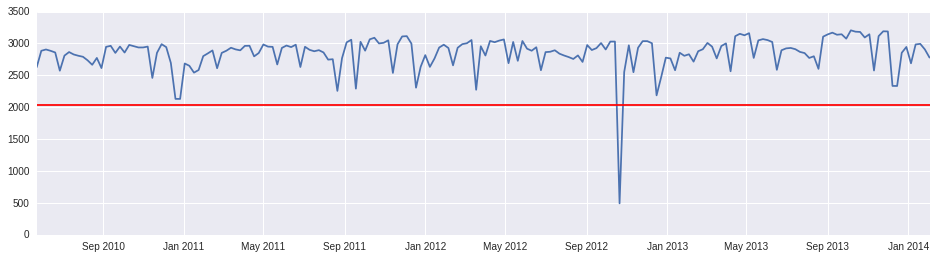

In [12]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
ax.plot(rng,allMeans)
ax.plot((rng[0], rng[193]), (threshold, threshold), 'r-')
ax.set_title('Ridership from May 2010 to February 2014')
ax.set_xlabel('Week')
ax.set_ylabel('Ridership from May 2010 to February 2014')
''

### Figure 1
The plot shows the ridership for every line and every card type, throughout 194 weeks. As we can see, ridership fluctuates around 2500 and 3000 trips per week, with one exception. During one week, it drops to only 500 rides, crossing the stablished threshold (2000 rides). This is the only moment in the series that something like that occurs. 

In [25]:
print' The event was around the week of %s' % (str(rng[np.where(allMeans<threshold)[0][0]]))[:10]

 The event was around the week of 2012-10-21


For what we could learn about that week, one event appears to be the more meaningful

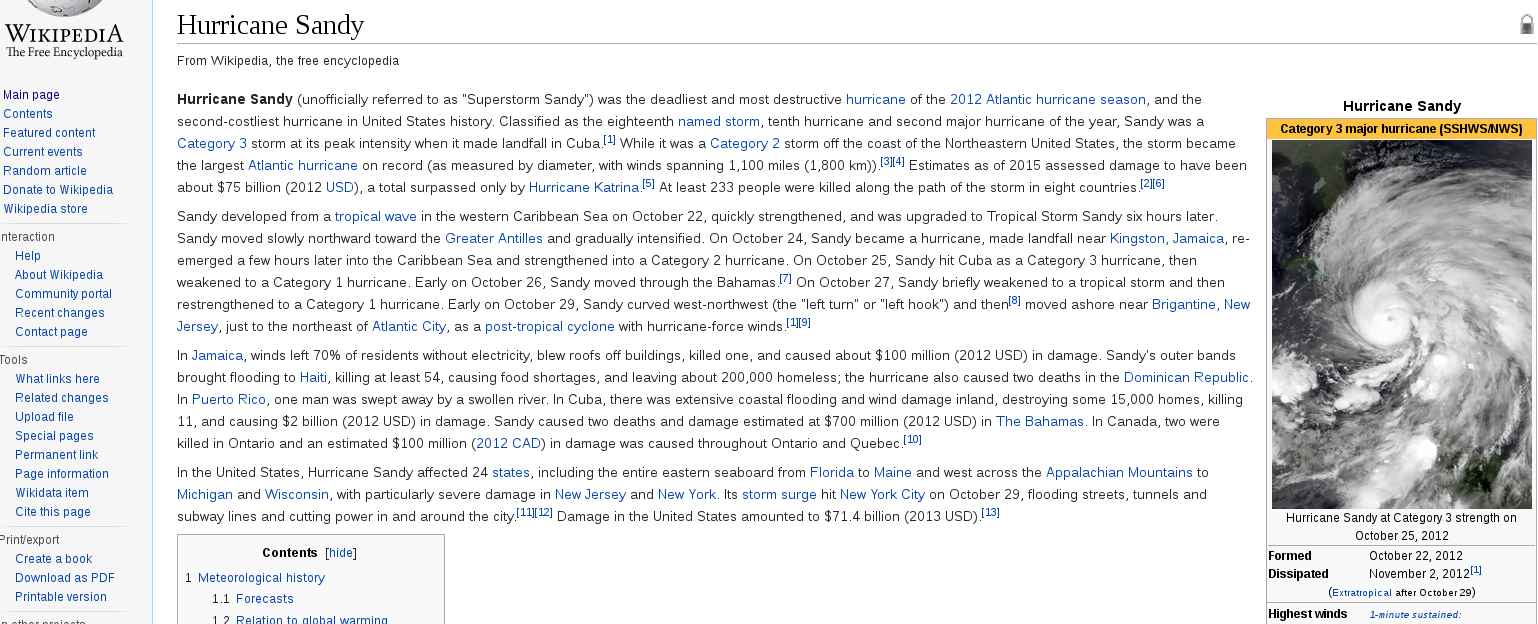

In [24]:
Image('img/sandy.png')


# Part II - Identifying the ridership types that have steadily increased in popularity, and that have steadily decreased. 

Another goal could be to examin every card type to see its usage during this period of time. This would allow to see increasing or decreasing popularity in types of cards. Based on this information, different policies could be enacted: from removing a specific type of card due to low usage, to change the price of a trip for a car type based on an increasing popularity that could endanger the bussines model.

In [21]:
riderMean = np.nanmean(data,axis=0)

In [22]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [37]:
def getSlope(riderMeanID):
    #take the rolling mean over 10 week
    series = pd.Series(riderMean[riderMeanID]).rolling(10).mean()
    #get only non na data
    Y = series[~pd.isnull(series)]
    #set de X
    xAxis = range(len(series[~pd.isnull(series)]))
    X = sm.add_constant(xAxis)
    #sun the model
    model = sm.OLS(Y,X).fit()
    
    #flux ratio 
    print 'flux ratio beginning to end ', Y[0:10].mean() / Y[-10:].mean()
    print 'Slope %s: %.2f' %(ridetype[riderMeanID],model.params[1]) 
    print 'Corr %s: %.2f' %(ridetype[riderMeanID],np.corrcoef(xAxis,Y)[0,1] * 100) 
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(111)
    ax.plot(series)
    ax.plot([9,193],[model.params[0],model.params[0] + 193*model.params[1]],'r-')
    #ax.plot([xAxis[0],xAxis[len(xAxis)]],[model.params[0],model.params[0] + xAxis[len(xAxis)]*model.params[1]],'r-')
    plt.show()


flux ratio beginning to end  0.95143647716
Slope 10t: 10.78
Corr 10t: 47.37


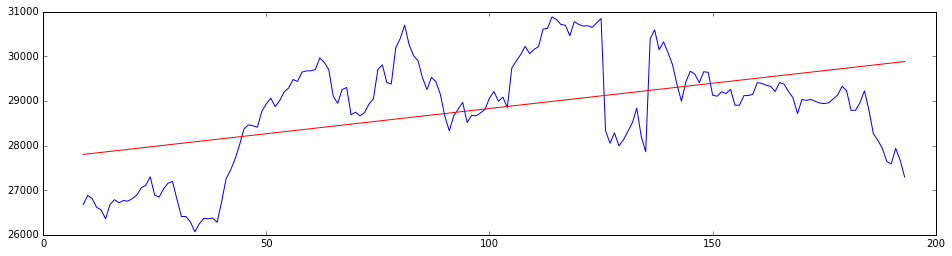

flux ratio beginning to end  0.739373645848
Slope 14d: 2.46
Corr 14d: 91.15


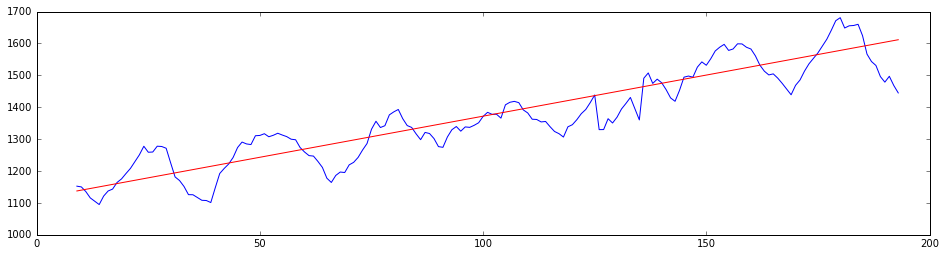

flux ratio beginning to end  0.846034554374
Slope 1d: 0.09
Corr 1d: 37.65


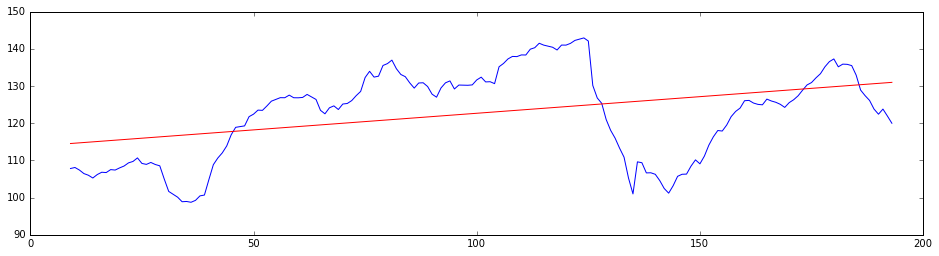

flux ratio beginning to end  1.01641393764
Slope 2t: -0.04
Corr 2t: -11.81


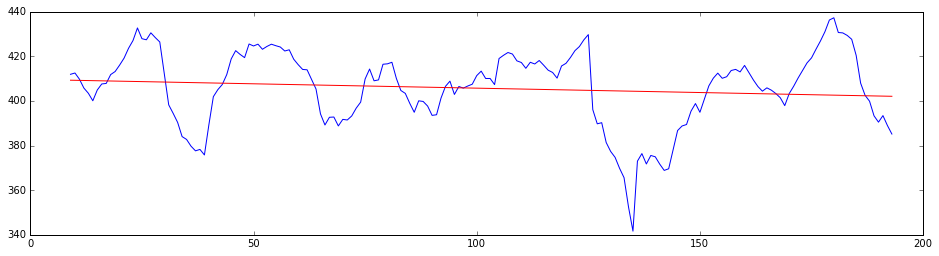

flux ratio beginning to end  0.893366472108
Slope 30d: 0.04
Corr 30d: 28.40


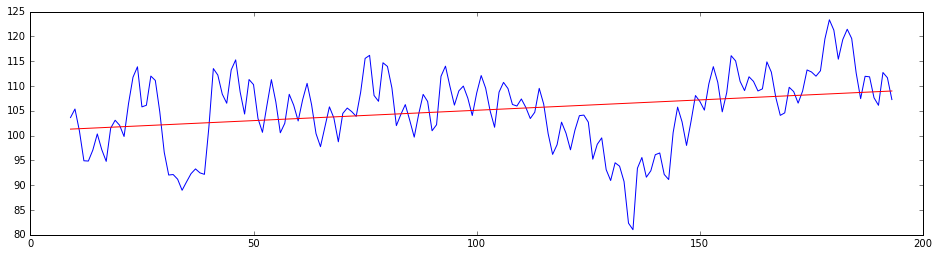

flux ratio beginning to end  0.692670321814
Slope 7d: 23.43
Corr 7d: 91.26


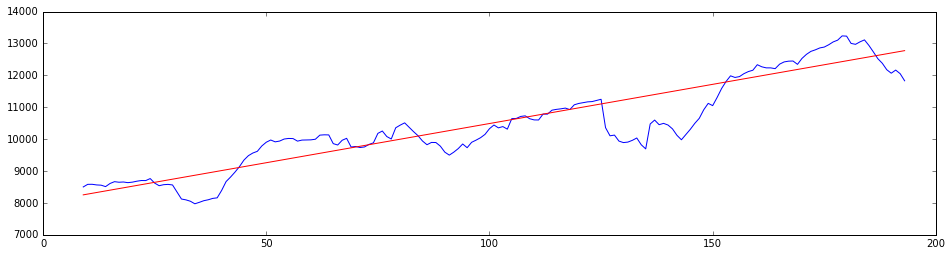

flux ratio beginning to end  1.0663619251
Slope ada: -3.75
Corr ada: -20.28


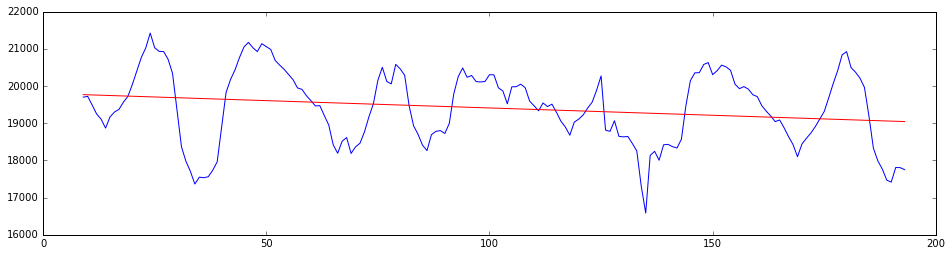

flux ratio beginning to end  4816.03746711
Slope afas: -0.10
Corr afas: -65.46


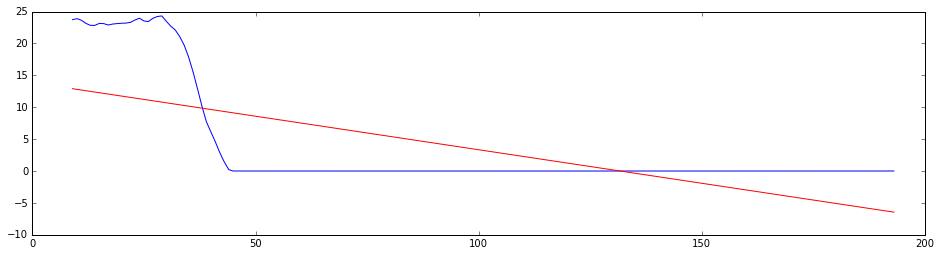

flux ratio beginning to end  94774.722111
Slope exp: -2.60
Corr exp: -63.53


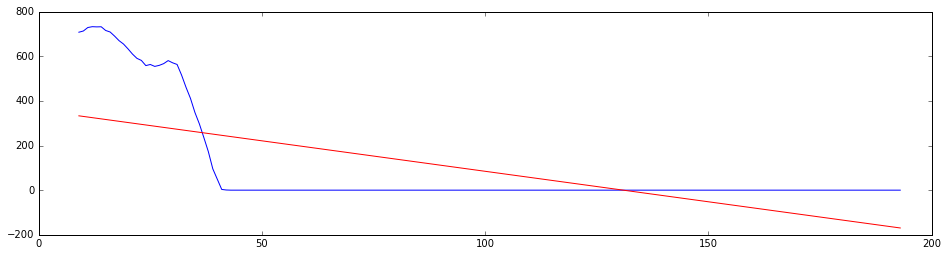

flux ratio beginning to end  511701.589294
Slope ez: -5.35
Corr ez: -64.21


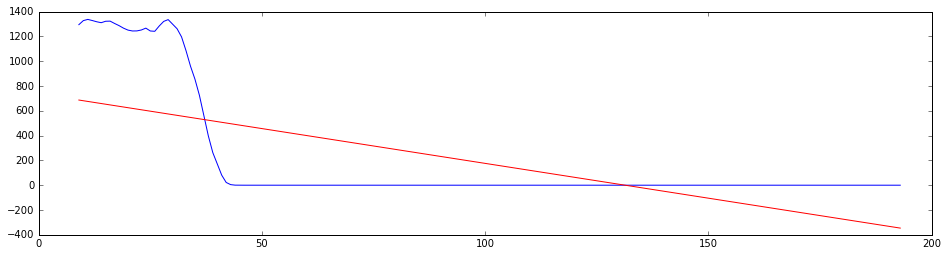

flux ratio beginning to end  1.14864285072
Slope ff: -0.13
Corr ff: -16.57


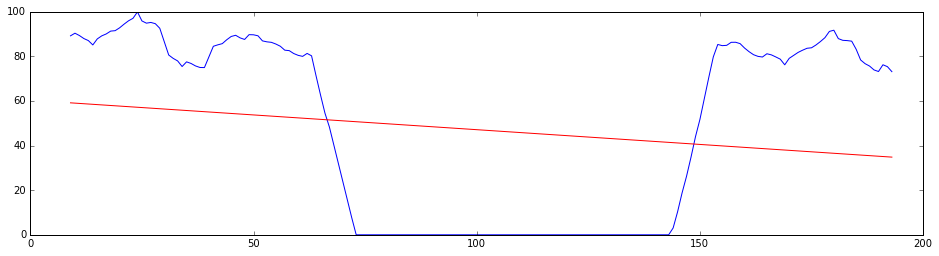

flux ratio beginning to end  0.799202982584
Slope mc: 0.28
Corr mc: 27.75


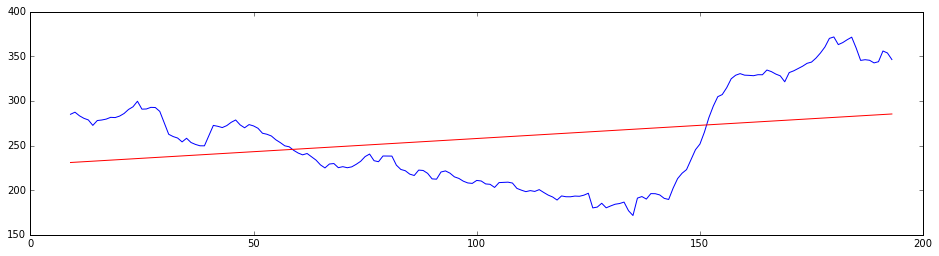

flux ratio beginning to end  3.13786657458e-05
Slope mr: 1.89
Corr mr: 76.15


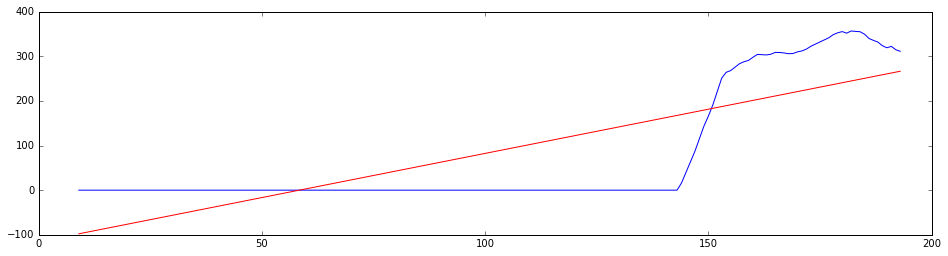

flux ratio beginning to end  1.61807327133
Slope month: -0.64
Corr month: -93.55


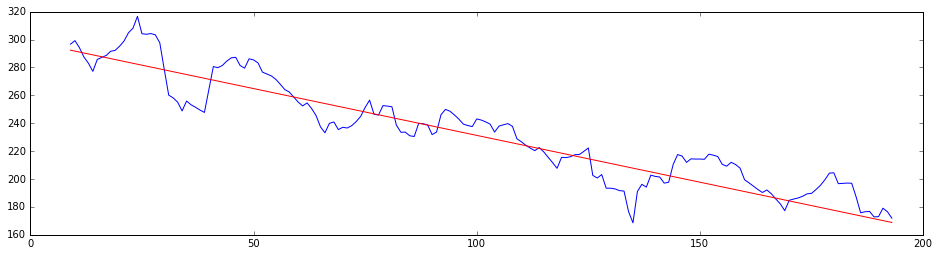

flux ratio beginning to end  1.51056516616
Slope rfm: -2.38
Corr rfm: -38.75


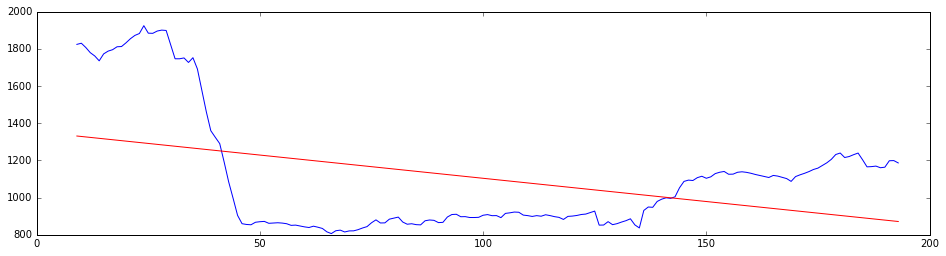

flux ratio beginning to end  0.379748667728
Slope rr: 1.34
Corr rr: 98.33


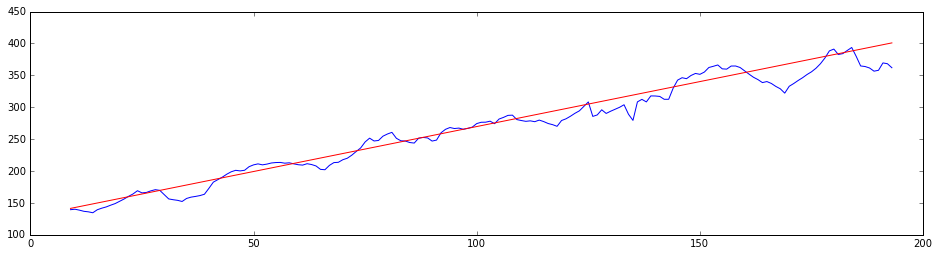

flux ratio beginning to end  0.350964310769
Slope sen: 0.73
Corr sen: 98.26


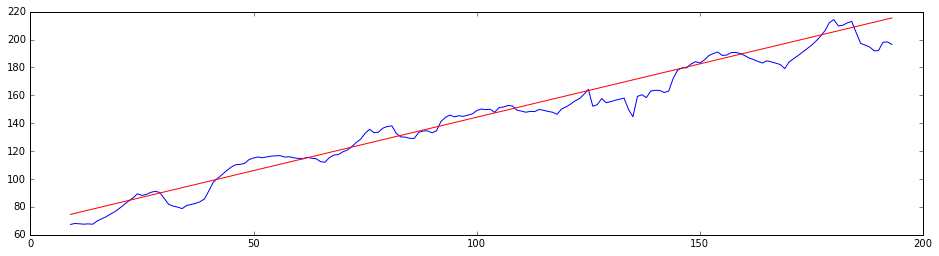

flux ratio beginning to end  0.183848220357
Slope spec: 0.32
Corr spec: 77.05


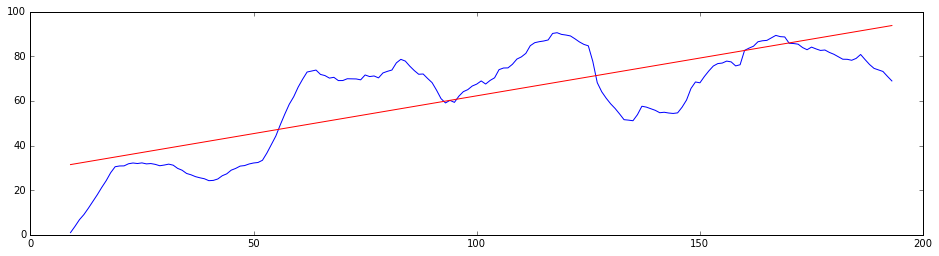

flux ratio beginning to end  0.630843926507
Slope tcmc: 1.02
Corr tcmc: 82.05


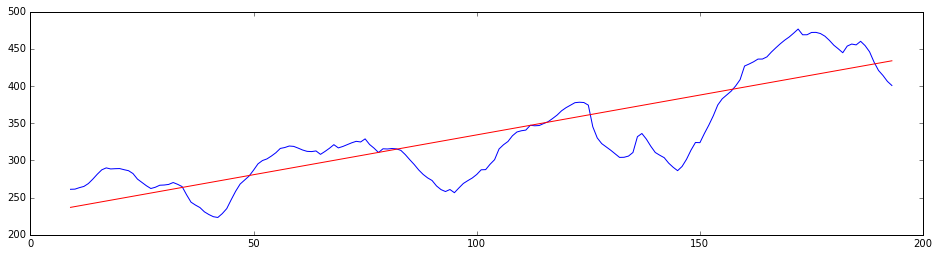

flux ratio beginning to end  0.947536611274
Slope t: 0.01
Corr t: 16.14


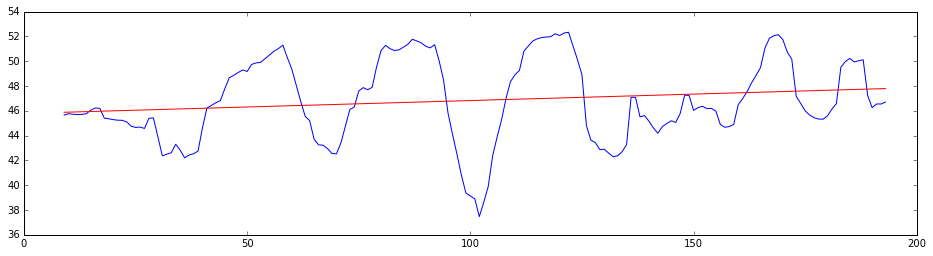

flux ratio beginning to end  1.23233946024
Slope umlim: 0.00
Corr umlim: 3.64


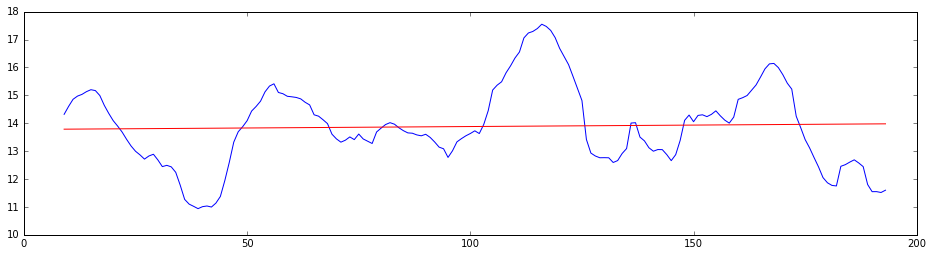

flux ratio beginning to end  0.52543417205
Slope xbus: 0.01
Corr xbus: 83.25


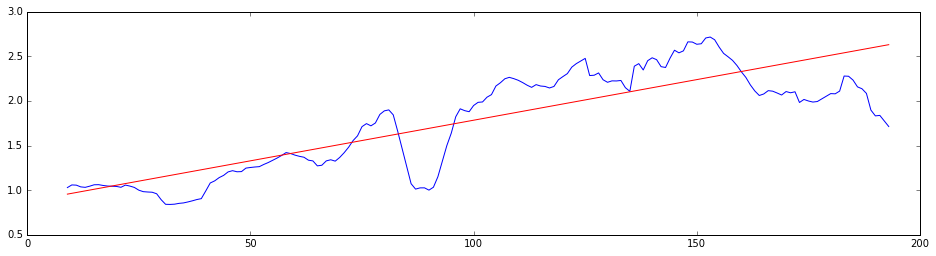

flux ratio beginning to end  1.11704676216
Slope stud: -5.37
Corr stud: -14.40


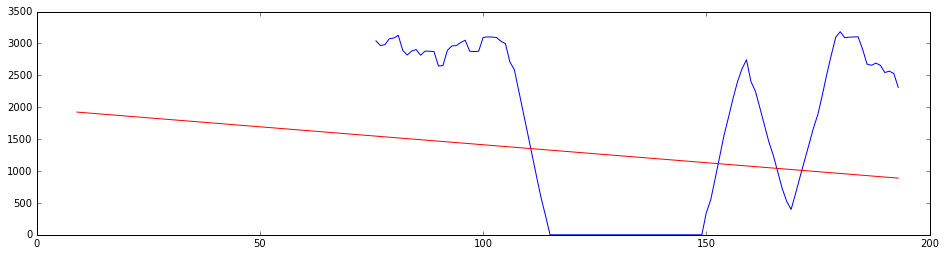

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [38]:
[getSlope(x) for x in range(23)]

Slope rr: 1.34
Corr rr: 98.33


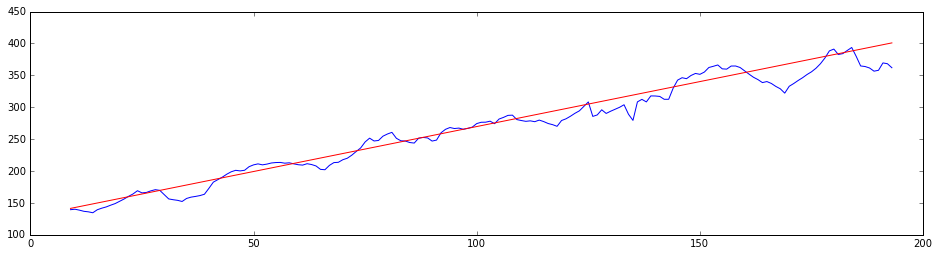

In [261]:
#Higest rr rail road
getSlope(15)

flux ratio beginning to end  0.350964310769
Slope sen: 0.73
Corr sen: 98.26


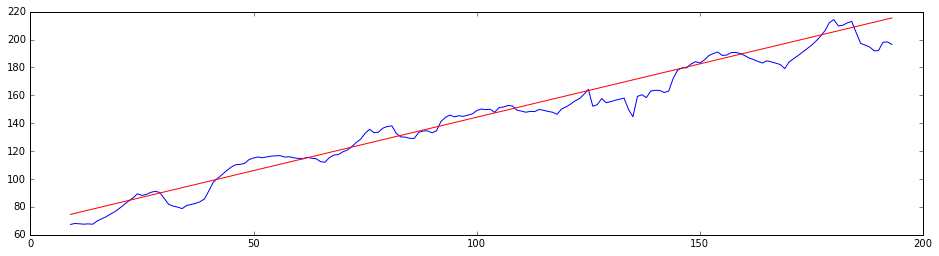

In [41]:
#Higest  sen - senior citizen
getSlope(16)

flux ratio beginning to end  1.61807327133
Slope month: -0.64
Corr month: -93.55


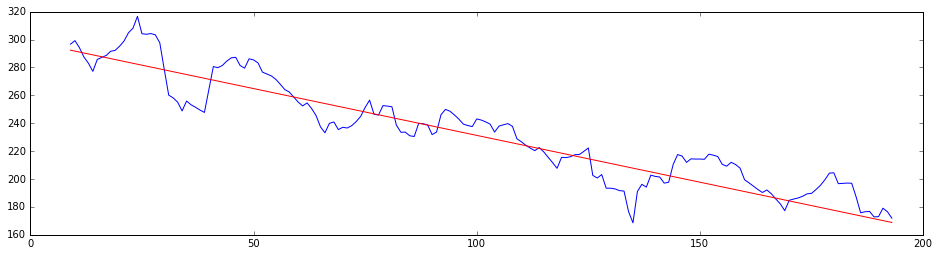

In [40]:
#lowest month
getSlope(13)

# Part III - Subway stations with annual periodicity

In [49]:
stationsMean = np.nanmean(data,axis=1)

In [94]:
#frequency of the 
stationsMean.shape

(600, 194)

We have a dataset that for each of the 600 stations has the average ridership across all card types over 194 weeks. We need to know, for a Fourier transformation, which element of the resulting frequency corresponds to the annual cycle that we are interested in (52 weeks). The function np.fft.rfftfreq(N, d) gives the frequency in a 1/week type of format. So we need to convert this into weeks.

In [96]:
1 / np.fft.rfftfreq(194, 1.0)

array([          inf,  194.        ,   97.        ,   64.66666667,
         48.5       ,   38.8       ,   32.33333333,   27.71428571,
         24.25      ,   21.55555556,   19.4       ,   17.63636364,
         16.16666667,   14.92307692,   13.85714286,   12.93333333,
         12.125     ,   11.41176471,   10.77777778,   10.21052632,
          9.7       ,    9.23809524,    8.81818182,    8.43478261,
          8.08333333,    7.76      ,    7.46153846,    7.18518519,
          6.92857143,    6.68965517,    6.46666667,    6.25806452,
          6.0625    ,    5.87878788,    5.70588235,    5.54285714,
          5.38888889,    5.24324324,    5.10526316,    4.97435897,
          4.85      ,    4.73170732,    4.61904762,    4.51162791,
          4.40909091,    4.31111111,    4.2173913 ,    4.12765957,
          4.04166667,    3.95918367,    3.88      ,    3.80392157,
          3.73076923,    3.66037736,    3.59259259,    3.52727273,
          3.46428571,    3.40350877,    3.34482759,    3.28813

As we can see, the 4th element is the one closest to the annual cycle we are interested in. Therefore, we need to find wich lines has the highest spectrum power for that cycle. 

In [128]:
def getSpectrum(stationId):
    f = np.abs(np.fft.rfft(stationsMean[stationId]))[4]
    return f


In [129]:
stationsSpectrum = pd.Series()
[stationsSpectrum.set_value(i, getSpectrum(i)) for i in range(stationsMean.shape[0])]

[0               NaN
 1               NaN
 2        909.333322
 3       3383.070590
 4       1815.397225
 5       2636.697318
 6        877.095265
 7       2402.550907
 8       1564.447833
 9      18938.084883
 10     20687.308397
 11     21395.181595
 12      9223.232807
 13     39732.216291
 14              NaN
 15      2672.692973
 16     12435.117451
 17     42525.481025
 18      8315.998200
 19     49395.717951
 20     26909.081440
 21     12097.523387
 22     28255.176280
 23     14298.250974
 24      8559.708167
 25              NaN
 26     27310.059118
 27     35408.301328
 28     35703.146412
 29     10553.899375
            ...     
 570             NaN
 571             NaN
 572             NaN
 573             NaN
 574             NaN
 575             NaN
 576             NaN
 577             NaN
 578             NaN
 579             NaN
 580             NaN
 581             NaN
 582             NaN
 583             NaN
 584             NaN
 585             NaN
 586         

In [189]:
annualCycleStations = stationsSpectrum.sort_values(ascending=False)[:4]
annualCycleStations.index

Int64Index([194, 150, 32, 327], dtype='int64')

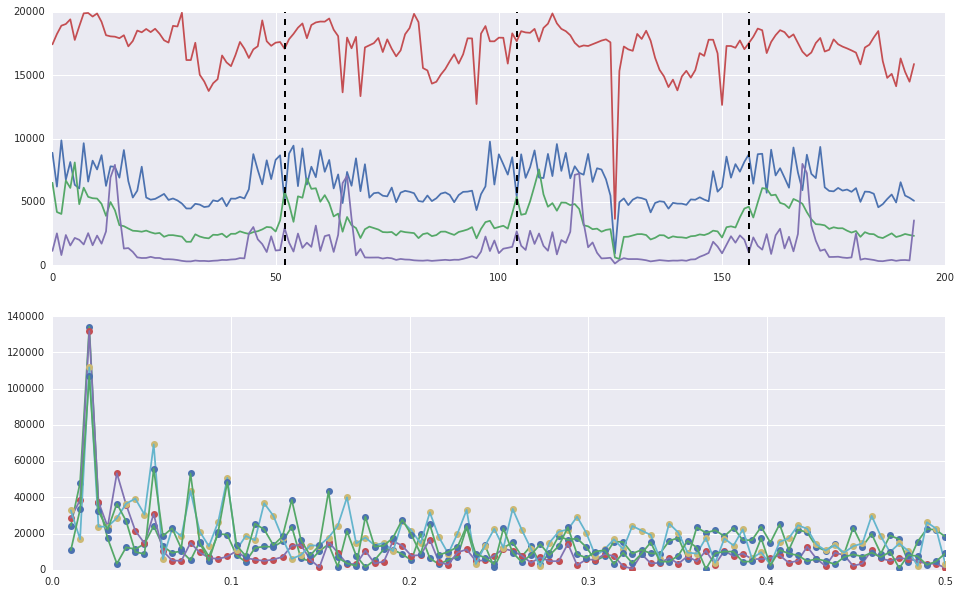

In [154]:
fig=plt.figure(figsize=(16,10))
    
for plotId in [1,2]:
    ax = fig.add_subplot(2,1,plotId)
    for i in annualCycleStations.index:
        if(plotId == 1):
            ax.plot(stationsMean[i])
            ax.plot([52,52],[0,20000],'k--')
            ax.plot([104,104],[0,20000],'k--')
            ax.plot([156,156],[0,20000],'k--')
        else:
            f = np.abs(np.fft.rfft(stationsMean[i]))
            ax.plot(np.fft.rfftfreq(194, 1.0)[2:], (f[2:]), 'o')
            ax.plot(np.fft.rfftfreq(194, 1.0)[2:], (f[2:]), '-')
            

In [187]:
rng[p1]

Timestamp('2010-12-12 00:00:00', offset='W-SUN')

In [188]:
rng[p2]

Timestamp('2010-07-18 00:00:00', offset='W-SUN')

In [260]:
def plotPeek(stationID):
    fig=plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(rng,stationsMean[stationID])
    p1 = np.where(stationsMean[stationID]== max(stationsMean[stationID][:52]))[0]
    ax.plot([rng[p1],rng[p1]],[0,max(stationsMean[stationID])],'g--')
    ax.plot([rng[p1+52],rng[p1+52]],[0,max(stationsMean[stationID])],'g--')
    ax.plot([rng[p1+(52*2)],rng[p1+(52*2)]],[0,max(stationsMean[stationID])],'g--')
    ax.plot([rng[p1+(52*3)],rng[p1+(52*3)]],[0,max(stationsMean[stationID])],'g--')
    print rng[p1]

DatetimeIndex(['2010-06-06'], dtype='datetime64[ns]', freq=None)


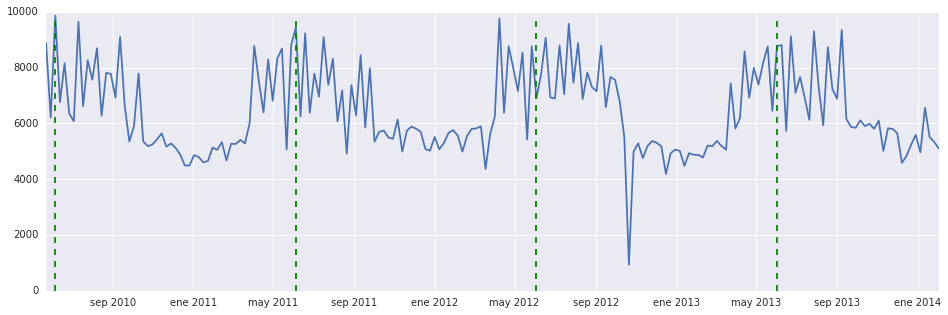

In [261]:
#194, 150, 32, 327
plotPeek(194)

DatetimeIndex(['2010-06-27'], dtype='datetime64[ns]', freq=None)


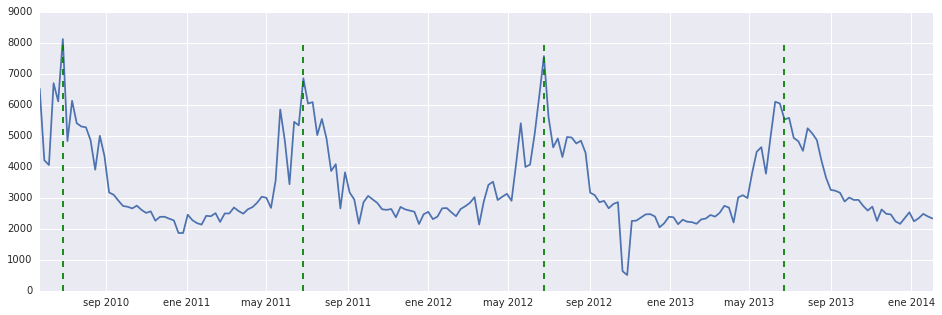

In [262]:
#194, 150, 32, 327
plotPeek(150)

DatetimeIndex(['2010-08-29'], dtype='datetime64[ns]', freq=None)


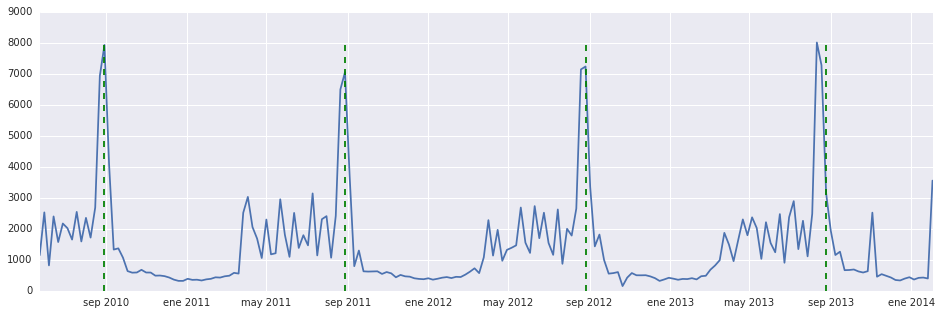

In [263]:
#194, 150, 32, 327
plotPeek(327)

DatetimeIndex(['2010-12-12'], dtype='datetime64[ns]', freq=None)


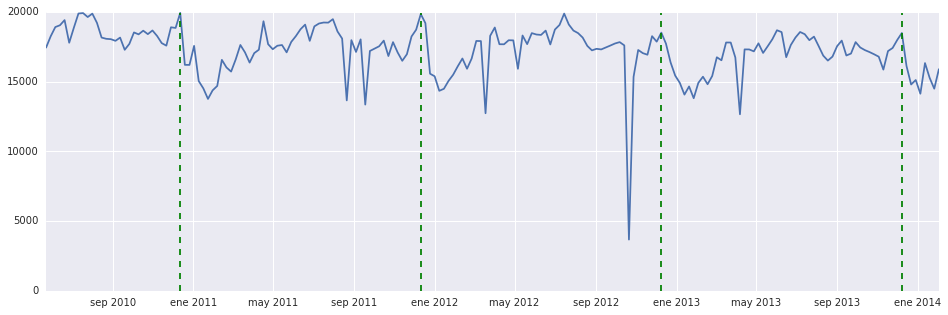

In [264]:
#194, 150, 32, 327
plotPeek(32)

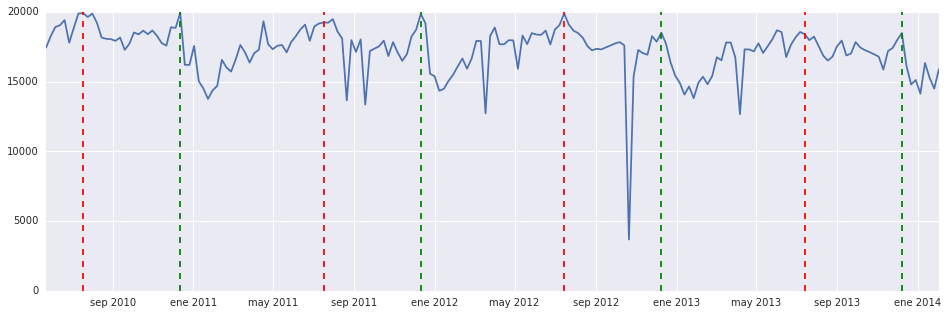

In [265]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,1,1)
ax.plot(rng,stationsMean[32])
p1 = 29
p2 = 8
ax.plot([rng[p1],rng[29]],[0,20000],'g--')
ax.plot([rng[p1+52],rng[p1+52]],[0,20000],'g--')
ax.plot([rng[p1+(52*2)],rng[p1+(52*2)]],[0,20000],'g--')
ax.plot([rng[p1+(52*3)],rng[p1+(52*3)]],[0,20000],'g--')

ax.plot([rng[p2],rng[p2]],[0,20000],'r--')
ax.plot([rng[p2+52],rng[p2+52]],[0,20000],'r--')
ax.plot([rng[p2+(52*2)],rng[p2+(52*2)]],[0,20000],'r--')
ax.plot([rng[p2+(52*3)],rng[p2+(52*3)]],[0,20000],'r--')


In [266]:
print rng[p1]

2010-12-12 00:00:00


In [267]:
print rng[p2]

2010-07-18 00:00:00
